# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# делим выборку на train, val, test (80%, 10%, 10%)
train, val = train_test_split(df, test_size=0.2, random_state=42)
test, val = train_test_split(val, test_size=0.5, random_state=42)

In [ ]:
# salary_in_usd в качестве таргета
train_y = train['salary_in_usd']
train_X = train.drop('salary_in_usd', axis=1)

val_y = val['salary_in_usd']
val_X = val.drop('salary_in_usd', axis=1)

test_y = test['salary_in_usd']
test_X = test.drop('salary_in_usd', axis=1)

In [ ]:
# удаление признака salary, из-за которого возможен лик в данных, т.к. нам как раз нужно предсказывать зарплату
train_X.drop('salary', axis=1, inplace=True)
val_X.drop('salary', axis=1, inplace=True)
test_X.drop('salary', axis=1, inplace=True)

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# OneHot-кодирование
categorical_features = train_X.columns[(train_X.dtypes == 'object').values]
encoder = OneHotEncoder(sparse=False, handle_unknown='infrequent_if_exist')

In [ ]:
X_train_encoded = pd.DataFrame(encoder.fit_transform(train_X[categorical_features]),
                                  columns=encoder.get_feature_names_out(categorical_features),
                                  index=train_X.index)
X_test_encoded = pd.DataFrame(encoder.transform(test_X[categorical_features]),
                                  columns=encoder.get_feature_names_out(categorical_features),
                                  index=test_X.index)
X_valid_encoded = pd.DataFrame(encoder.transform(val_X[categorical_features]),
                                  columns=encoder.get_feature_names_out(categorical_features),
                                  index=val_X.index)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# обучение модели линейной регрессии
lr = LinearRegression()
lr.fit(X_train_encoded, train_y)
pred_y_lr = lr.predict(X_test_encoded)

In [ ]:
print('MAPE: ', mean_absolute_percentage_error(test_y, pred_y_lr))
print('RMSE: ', mean_squared_error(test_y, pred_y_lr, squared=False))

MAPE:  150674690.92530096
RMSE:  55272704734584.72


Качество модели очень низкое, высокое среднеквадратическое отклонение прогнозируемых значений от фактических подтверждает это, как и огромная средняя разница между прогнозом и фактом

## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
import time

In [ ]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.4, 0.6, 0.8],
    'colsample_bytree': [0.4, 0.6, 0.8],
    'min_child_weight': [1, 3, 5]
}

xgb = XGBRegressor()
grid_search = GridSearchCV(estimator=xgb, param_grid=parameters, cv=3, n_jobs=-1)
grid_search.fit(X_valid_encoded, val_y)

In [ ]:
%%time
best_xgb = XGBRegressor(**grid_search.best_params_)
best_xgb.fit(X_train_encoded, train_y)

In [ ]:
%%time
pred_y_xgb = best_xgb.predict(X_test_encoded)

CPU times: user 39.9 ms, sys: 0 ns, total: 39.9 ms
Wall time: 37.3 ms


In [ ]:
print('MAPE: ', mean_absolute_percentage_error(test_y, pred_y_xgb))
print('RMSE: ', mean_squared_error(test_y, pred_y_xgb, squared=False))

MAPE:  0.4134873202401893
RMSE:  42435.727065011626


Обучение модели заняло 4.28 s, предсказание - 39.9 ms, что говорит о довольно низкой скорости обучения и средней скорости предсказания. Полученные значения MAPE и RMSE указывают на достаточно высокую точность модели.

## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
!pip3 install catboost

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
parameters = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5],
    'random_strength': [1, 2, 5]
}

cbr = CatBoostRegressor()
grid_search = GridSearchCV(estimator=cbr, param_grid=parameters, cv=3, n_jobs=-1)
grid_search.fit(X_valid_encoded, val_y)

In [ ]:
%%time
best_cbr = CatBoostRegressor(**grid_search.best_params_)
best_cbr.fit(X_train_encoded, train_y)

In [ ]:
%%time
pred_y_cbr = best_cbr.predict(X_test_encoded)

In [ ]:
print('MAPE: ', mean_absolute_percentage_error(test_y, pred_y_cbr))
print('RMSE: ', mean_squared_error(test_y, pred_y_cbr, squared=False))

MAPE:  0.35569628969667394
RMSE:  49806.73946627879


Обучение модели заняло 189 ms, предсказание - 34.4 ms, что говорит о средней скорости обучения и высокой скорости предсказания. Полученные значения MAPE и RMSE указывают на достаточно высокую точность модели.

Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [ ]:
from catboost import Pool
from sklearn.model_selection import RandomizedSearchCV

categorical_features = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']
pool_train = Pool(data=train_X, label=train_y, cat_features=categorical_features)
pool_val = Pool(data=val_X, label=val_y, cat_features=categorical_features)
pool_test = Pool(data=test_X, label=test_y, cat_features=categorical_features)

In [ ]:
parameters = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5],
    'random_strength': [1, 2, 5]
}

cbr_pool = CatBoostRegressor()
random_search = RandomizedSearchCV(estimator=cbr_pool, param_distributions=parameters, n_iter=50, cv=3, n_jobs=-1)
random_search.fit(val_X, val_y)

In [ ]:
%%time
best_cbr_pool = CatBoostRegressor(**random_search.best_params_)
best_cbr_pool.fit(pool_train)

In [ ]:
%%time
pred_y_cbr_pool = best_cbr_pool.predict(pool_test)

In [ ]:
print('MAPE: ', mean_absolute_percentage_error(test_y, pred_y_cbr_pool))
print('RMSE: ', mean_squared_error(test_y, pred_y_cbr_pool, squared=False))

MAPE:  0.35569628969667394
RMSE:  49806.73946627879


**Ответ:** Обучение модели стало занимать 2.9 ms, предсказание - 142.6 ms, что говорит о замедлении скорости работы модели, качество осталось прежним.

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [ ]:
from lightgbm import LGBMRegressor


parameters = {
    'max_depth' : [4, 6, 8],
    'learning_rate' : [0.01, 0.05, 0.1],
    'n_estimators' : [100, 150, 200],
    'num_leaves': [20, 50, 100],
    'reg_alpha': [0.0, 0.1, 0.5]
}

lgbmr = LGBMRegressor()
grid_search = GridSearchCV(estimator=lgbmr, param_grid=parameters, cv=3, n_jobs=-1)
grid_search.fit(X_valid_encoded, val_y)

In [ ]:
%%time
best_lgbmr = LGBMRegressor(**grid_search.best_params_)
best_lgbmr.fit(X_train_encoded, train_y)

In [ ]:
%%time
pred_y_lgbmr = best_lgbmr.predict(X_test_encoded)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: user 8.95 ms, sys: 0 ns, total: 8.95 ms
Wall time: 11 ms


In [ ]:
print('MAPE: ', mean_absolute_percentage_error(test_y, pred_y_lgbmr))
print('RMSE: ', mean_squared_error(test_y, pred_y_lgbmr, squared=False))

MAPE:  0.3600051162058447
RMSE:  41409.55306088991


Обучение модели заняло 398 ms, предсказание - 11 ms, что говорит о низкой скорости обучения и высокой скорости предсказания. Полученные значения MAPE и RMSE указывают на достаточно высокую точность модели.

## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** Сравним модели бустинга, по качеству предсказания лучший результат показала модель LightGBM, худший результат - линейная модель (очень большое значение отклонения, хотя и обучается быстро). Что касается скорости обучения, то выделяются следующие модели: линейная обучается действительно быстро, а вот XGboost пришлось доооолго ждать :( По скорости предсказания лидирует модель LightGBM, а CatBoost - это вообще кошмар (особенно с pool)!

Можно сказать, что лучше всего для данной задачи выбрать LightGBM, т.к. скорости обучения и предсказания удовлетворительные, а точность предсказаний высокая.

Гиперпараметры для разных моделей отличаются, однако имеют такие общие параметры, как learning_rate (скорость обучения модели), max_depth (максимальная глубина деревьев), min_child_weight (минимальный вес для разделения узла).

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [ ]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [ ]:
ratings = ratings.T

Выкиньте строку под названием `user`.

In [ ]:
ratings = ratings.drop('user', axis=0)

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [ ]:
ratings = ratings.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
antony; johnsons,0.0,0.0,0.0,0.0,0.0,0.102725,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [ ]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters = 5)
k_means = k_means.fit(ratings)
clusters = k_means.predict(ratings)

labels = k_means.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [ ]:
ratings['cluster'] = labels

clust0 = ratings[ratings['cluster'] == 0]
clust1 = ratings[ratings['cluster'] == 1]
clust2 = ratings[ratings['cluster'] == 2]
clust3 = ratings[ratings['cluster'] == 3]
clust4 = ratings[ratings['cluster'] == 4]

print(f"Размеры кластеров: {len(clust0)}, {len(clust1)}, {len(clust2)}, {len(clust3)}, {len(clust4)}")

Размеры кластеров: 30, 967, 1, 1, 1


**Ответ:** Кластеризация получилась бесполезной, KMeans может выдать такой результат из-за проблем с выбором начального приближения и метрики расстояния, связанных со случайной инициализации центров кластеров.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [ ]:
print('Исполнители:', *ratings[ratings['cluster'] == 2].index, *ratings[ratings['cluster'] == 3].index, *ratings[ratings['cluster'] == 4].index, sep='\n')

Исполнители:
sonic youth
various korean artists
the beatles


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [ ]:
ratings[ratings['cluster'] == 4]

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,cluster
the beatles,0.0,0.0,0.0,0.0,0.043529,0.0,0.0,0.0,0.093398,0.017621,...,0.0,0.121169,0.038168,0.007939,0.017884,0.0,0.076923,0.0,0.0,4


In [ ]:
mean_listen_share = ratings.mean().mean()
print(f'Средняя доля прослушивания: {mean_listen_share:.7f}')
print(f'Доля прослушивания the beatles относительно остальных: {ratings.iloc[0].mean()/mean_listen_share:.7f}')

Средняя доля прослушивания: 0.0009950
Доля прослушивания the beatles относительно остальных: 19.2614315


**Ответ:** the beatles выделяется среди остальных тем, что их слушают гораздо чаще остальных исполнителей, поэтому они выделились в отдельный кластер как выброс (если так можно выразиться).

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [ ]:
from sklearn.preprocessing import normalize

ratings_normalized = pd.DataFrame(normalize(ratings, axis=1), columns=ratings.T.index.astype(str)).set_index(ratings.index)

In [ ]:
ratings_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,cluster
the beatles,0.000000,0.000000,0.000000,0.0,0.008078,0.000000,0.0,0.0,0.017331,0.003270,...,0.0,0.022485,0.007083,0.001473,0.003319,0.0,0.014274,0.0,0.000000,0.742265
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622,0.000000
coldplay,0.000000,0.000000,0.000000,0.0,0.004981,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.894235
modest mouse,0.000000,0.000000,0.000000,0.0,0.006293,0.000000,0.0,0.0,0.000000,0.012020,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.789817


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [ ]:
k_means = KMeans(n_clusters = 5)
k_means = k_means.fit(ratings_normalized)
clusters = k_means.predict(ratings_normalized)

labels = k_means.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
ratings_normalized['cluster'] = labels

clust0 = ratings_normalized[ratings_normalized['cluster'] == 0]
clust1 = ratings_normalized[ratings_normalized['cluster'] == 1]
clust2 = ratings_normalized[ratings_normalized['cluster'] == 2]
clust3 = ratings_normalized[ratings_normalized['cluster'] == 3]
clust4 = ratings_normalized[ratings_normalized['cluster'] == 4]

print(f"Размеры кластеров: {len(clust0)}, {len(clust1)}, {len(clust2)}, {len(clust3)}, {len(clust4)}")

Размеры кластеров: 195, 196, 372, 164, 73


**Ответ:** Качество кластеризации улучшилось, потому что нормализация минимизирует различия внутри групп, что помогает точнее определить центры кластеров и учесть общую дисперсию данных для каждого кластера.

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [ ]:
from scipy.spatial.distance import cosine

centroids = k_means.cluster_centers_

cosine_distances = np.zeros((len(centroids), len(ratings)))
for i, centroid in enumerate(centroids):
    for j, artist_vector in enumerate(ratings.values):
        cosine_distances[i, j] = cosine(centroid, artist_vector)

artists = {}
for i in range(len(centroids)):
    artists[i] = [ratings.index[index] for index in np.argsort(cosine_distances[i])[:10]]
    print(f"clust{i}: ", end='')
    print(*artists[i], sep=', ')

clust0: kelly clarkson, john mayer, maroon5, imogen_heap, ﻿sarah mclachlan, the killers, snow potrol, sara bareilles, johnson jack, evril lavigne
clust1: radiohead, animal collective, broken social scene, the arcade fire, sufjan stevens, belle and sebastian, of montreal, beirut, the shins, andrew bird
clust2: the rolling stones, the clash, led zeppelin., radiohead, dylan. bob, white stripes, pink fluid, the ramones, acdc, metallica
clust3: brand new, fall out boy, blink-182, taking back sunday, new found glory, saosin, anberlin, cartel, chiodos, the used
clust4: nas, jay-z, kanye west, lupe the gorilla, the roots featuring d'angelo, the game, lil' wayne, a tribe called quest, little brother, mos def


**Ответ:** Полученную кластеризацию можно проинтерпретировать по жанрам, т.е. clust0 содержит наиболее популярных исполнителей попа, clust1 - инди-рок-музыкантов, clust2 - рок-групп, clust3 выделяет панк-исполнителей, clust4 - рэперов.

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

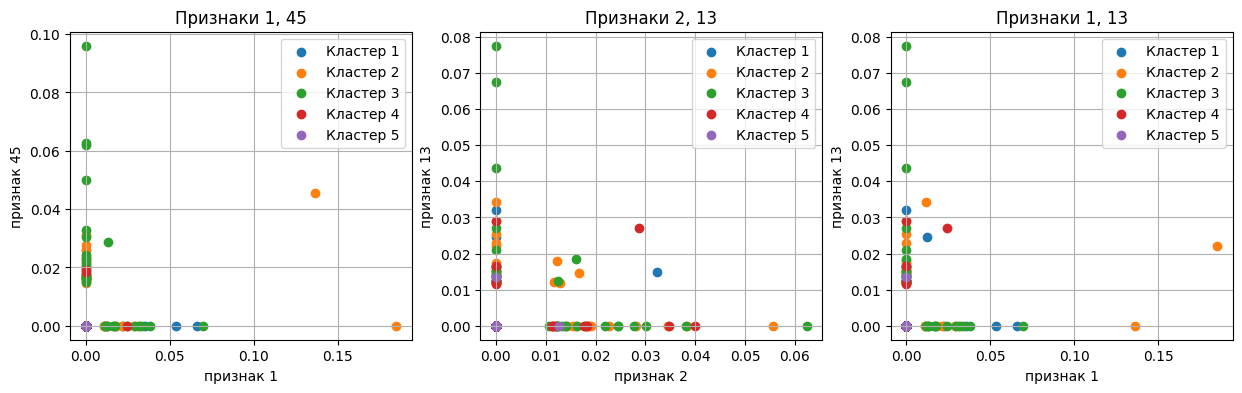

In [ ]:
import matplotlib.pyplot as plt

feature_pairs = [(1, 45), (2, 13), (1, 13)]
plt.figure(figsize=(15, 4))

for i, (feature1_index, feature2_index) in enumerate(feature_pairs, 1):
    plt.subplot(1, 3, i)
    for label in range(len(np.unique(labels))):
        plt.scatter(ratings.loc[labels == label, feature1_index], ratings.loc[labels == label, feature2_index], label=f'Кластер {label+1}')

    plt.title(f'Признаки {ratings.columns[feature1_index]}, {ratings.columns[feature2_index]}')
    plt.xlabel(f'признак {ratings.columns[feature1_index]}')
    plt.ylabel(f'признак {ratings.columns[feature2_index]}')
    plt.legend()
    plt.grid(True)

plt.show()

**Ответ:** Визуализация получилась плохо отражающей разделение на кластеры из-за того, что зависимость по 2 случайным исполнителям может отсутствовать. Нужно смотреть на все признаки.

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

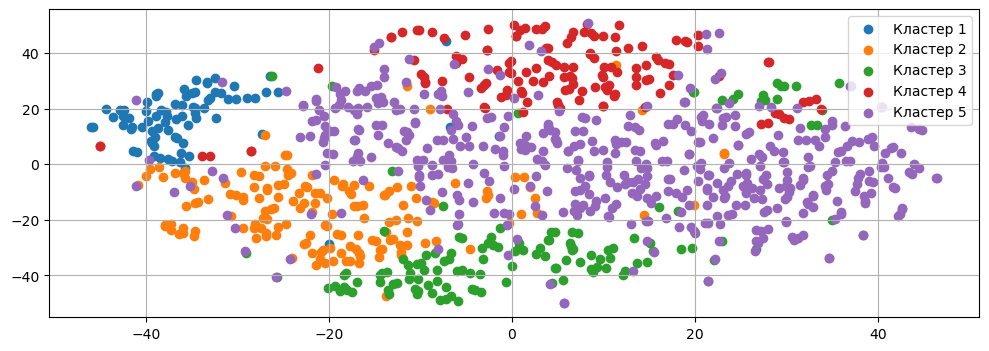

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
data = tsne.fit_transform(ratings)

plt.figure(figsize=(12, 4))
for label in range(len(np.unique(labels))):
    plt.scatter(data[labels == label, 0], data[labels == label, 1], label=f'Кластер {label+1}')

plt.grid(True)
plt.legend()
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [ ]:
from sklearn.metrics import silhouette_score

best_k, best_score = None, -1
for k in range(2, 101):
    k_means = KMeans(n_clusters = k, random_state=42)
    k_means = k_means.fit(ratings_normalized)
    score = np.round(silhouette_score(X=ratings_normalized,
                             labels=k_means.labels_), 2)
    if score >= best_score:
      best_score = score
      best_k = k

In [ ]:
print(f'Best score {best_score}, best_k = {best_k}')

Best score 0.39, best_k = 82


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [ ]:
k_means = KMeans(best_k + 2, random_state=42)
k_means.fit(ratings)
labels = k_means.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [ ]:
centroids = k_means.cluster_centers_

cosine_distances = np.zeros((len(centroids), len(ratings)))
for i, centroid in enumerate(centroids):
    for j, artist_vector in enumerate(ratings.values):
        cosine_distances[i, j] = cosine(centroid, artist_vector)

artists = {}
for i in range(len(centroids)):
    artists[i] = [ratings.index[index] for index in np.argsort(cosine_distances[i])[:10]]
    print(f"clust{i}: ", end='')
    print(*artists[i], sep=', ')

clust0: raekwon, wu-tang clan, gza/genius, ghostface killah, mobb deep, cypress hill, nas, gangstarr, jay-z, a tribe called quest
clust1: she wants revenge, shiny toy guns, the bravery, pink*, mika, three days grase, placebo, frou frou, digitalism, the dandy warhols
clust2: vampire weekend, mgmt, girl talk, the go! team, the blow, dr. dog, bishop allen, the dodos, of montreal, the shins
clust3: the flaming lips, the apples in stereo, elvis costello and the attractions, grandaddy, the notwist, sparklehorse, orbital, elvis costello, sigur rós, m. ward
clust4: the smashing pumpkins, vnv nation, the blood brothers, moby, the pillows, niИ, system of a down, rammstein, radiohead, air
clust5: all time low, mayday parade, forever the sickest kids, fall out boy, cute is what we aim for, the academy is..., cobra starship, paramore, the spill canvas, boys like girls
clust6: kanye west, jay-z, lupe the gorilla, lil' wayne, t.i., ludacris, t-pain, drake, chris brown, nas
clust7: iron maiden, megade

**Ответ:** Результаты соотносятся прежними +- одинаково, смысл кластеризации остался прежним - по жанрам, только теперь деление происходит более точно, ну и кластеров гораздо больше, поэтому рассмотрим только 2 - clust6 и clust46.

clust6: kanye west, jay-z, lupe the gorilla, lil' wayne, t.i., ludacris, t-pain, drake, chris brown, nas - это кластер рэперов.

clust46: lady gaga, brritney spears, pink*, tatu, rihanna & jay-z, veronicas, cascada, timbaland, ‌linkin park, madonna - это кластер известных и очень популярных поп-исполнителей.



Сделайте t-SNE визуализацию полученной кластеризации.

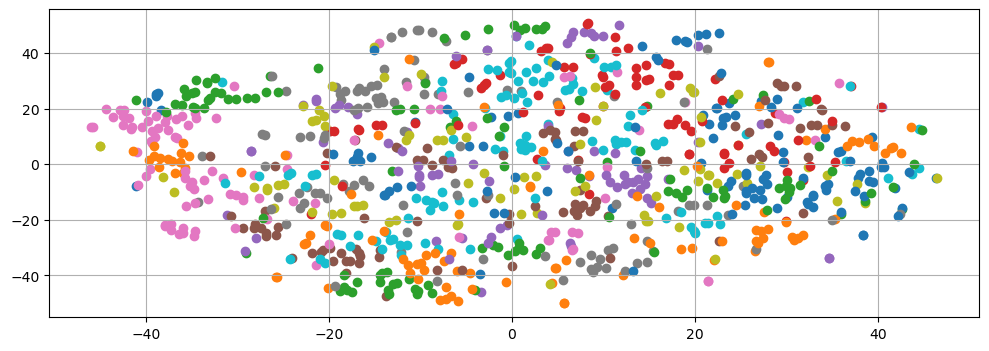

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
data = tsne.fit_transform(ratings)

plt.figure(figsize=(12, 4))
for label in range(len(np.unique(labels))):
    plt.scatter(data[labels == label, 0], tsne[labels == label, 1])

plt.grid(True)
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

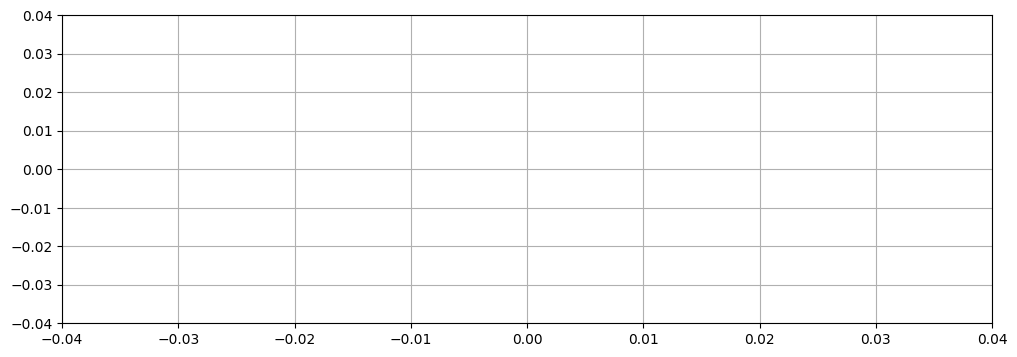

In [ ]:
plt.figure(figsize=(12, 4))

plt.scatter(data[labels == 46, 0], data[labels == 46, 1])

plt.grid(True)
plt.show()

**Ответ:** Точки не отобразились почему-то(( и сеаес прервался, заново запускать я не стала код, слишком долго думает (чуть ли не по 40 минут..), так что не могу определить, насколько хорошо кластер определяется в кластеризации.